In [179]:
import warnings
warnings.filterwarnings('ignore')

from io import StringIO
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.metrics import mean_squared_error
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.figure_factory as ff
import plotly

def set_pandas_display_options() -> None:
    """Set pandas display options."""
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    display.precision = 15  # set as needed
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

set_pandas_display_options()

### Train and Test Data Loading and Viewing

In [180]:
trainDf = pd.read_csv('train.csv')
trainDf.replace("nan", np.nan, inplace=True)
trainDf.dropna(how = 'all')

testDf = pd.read_csv('test.csv')
testDf.replace("nan", np.nan, inplace=True)
testDf.dropna(how = 'all')

# Changing the names of the column - replacing whitespace with underscore(_)
trainDf.columns = ['_'.join(col.split(' ')) for col in trainDf.columns]
testDf.columns = ['_'.join(col.split(' ')) for col in testDf.columns]

target_feat = 'Credit_Default'

print(f"\nTrain Data Size : {trainDf.shape}")
print(f"Test Data Size : {testDf.shape}")

print(f"\n\n:: Train Data Sample ::")
display(trainDf.head())

print(f"\n\n:: Transposed Train Data ::")
display(trainDf.T)

print(f"\n\n:: Transposed Test Data ::")
display(testDf.T)


Train Data Size : (7500, 18)
Test Data Size : (2500, 17)


:: Train Data Sample ::


Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0   0       Own Home     482087.000                  NaN      0.000   
1   1       Own Home    1025487.000            10+ years      0.000   
2   2  Home Mortgage     751412.000              8 years      0.000   
3   3       Own Home     805068.000              6 years      0.000   
4   4           Rent     776264.000              8 years      0.000   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                   11.000                   26.300           685960.000   
1                   15.000                   15.300          1181730.000   
2                   11.000                   35.000          1182434.000   
3                    8.000                   22.500           147400.000   
4                   13.000                   13.600           385836.000   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                      1.000                           nan         1.000   
1                      0.000                           nan         0.000   
2                      0.000                           nan         0.000   
3                      1.000                           nan         1.000   
4                      1.000                           nan         0.000   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term         99999999.000   
1  debt consolidation   Long Term           264968.000   
2  debt consolidation  Short Term         99999999.000   
3  debt consolidation  Short Term           121396.000   
4  debt consolidation  Short Term           125840.000   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0               47386.000      7914.000       749.000               0  
1              394972.000     18373.000       737.000               1  
2              308389.000     13651.000       742.000               0  
3               95855.000     11338.000       694.000               0  
4               93309.000      7180.000       719.000               0



:: Transposed Train Data ::


0                   1     \
Id                                             0                   1   
Home_Ownership                          Own Home            Own Home   
Annual_Income                         482087.000         1025487.000   
Years_in_current_job                         NaN           10+ years   
Tax_Liens                                  0.000               0.000   
Number_of_Open_Accounts                   11.000              15.000   
Years_of_Credit_History                   26.300              15.300   
Maximum_Open_Credit                   685960.000         1181730.000   
Number_of_Credit_Problems                  1.000               0.000   
Months_since_last_delinquent                 NaN                 NaN   
Bankruptcies                               1.000               0.000   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term           Long Term   
Current_Loan_Amount                 99999999.000          264968.000   
Current_Credit_Balance                 47386.000          394972.000   
Monthly_Debt                            7914.000           18373.000   
Credit_Score                             749.000             737.000   
Credit_Default                                 0                   1   

                                            2                   3     \
Id                                             2                   3   
Home_Ownership                     Home Mortgage            Own Home   
Annual_Income                         751412.000          805068.000   
Years_in_current_job                     8 years             6 years   
Tax_Liens                                  0.000               0.000   
Number_of_Open_Accounts                   11.000               8.000   
Years_of_Credit_History                   35.000              22.500   
Maximum_Open_Credit                  1182434.000          147400.000   
Number_of_Credit_Problems                  0.000               1.000   
Months_since_last_delinquent                 NaN                 NaN   
Bankruptcies                               0.000               1.000   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term          Short Term   
Current_Loan_Amount                 99999999.000          121396.000   
Current_Credit_Balance                308389.000           95855.000   
Monthly_Debt                           13651.000           11338.000   
Credit_Score                             742.000             694.000   
Credit_Default                                 0                   0   

                                            4          5     \
Id                                             4          5   
Home_Ownership                              Rent       Rent   
Annual_Income                         776264.000        NaN   
Years_in_current_job                     8 years    7 years   
Tax_Liens                                  0.000      0.000   
Number_of_Open_Accounts                   13.000     12.000   
Years_of_Credit_History                   13.600     14.600   
Maximum_Open_Credit                   385836.000 366784.000   
Number_of_Credit_Problems                  1.000      0.000   
Months_since_last_delinquent                 NaN        NaN   
Bankruptcies                               0.000      0.000   
Purpose                       debt consolidation      other   
Term                                  Short Term  Long Term   
Current_Loan_Amount                   125840.000 337304.000   
Current_Credit_Balance                 93309.000 165680.000   
Monthly_Debt                            7180.000  18692.000   
Credit_Score                             719.000        NaN   
Credit_Default                                 0          1   

                                           6           7     \
Id                                           



:: Transposed Test Data ::


0                     1     \
Id                                          7500                  7501   
Home_Ownership                              Rent                  Rent   
Annual_Income                                NaN            231838.000   
Years_in_current_job                     4 years                1 year   
Tax_Liens                                  0.000                 0.000   
Number_of_Open_Accounts                    9.000                 6.000   
Years_of_Credit_History                   12.500                32.700   
Maximum_Open_Credit                   220968.000             55946.000   
Number_of_Credit_Problems                  0.000                 0.000   
Months_since_last_delinquent              70.000                 8.000   
Bankruptcies                               0.000                 0.000   
Purpose                       debt consolidation  educational expenses   
Term                                  Short Term            Short Term   
Current_Loan_Amount                   162470.000             78298.000   
Current_Credit_Balance                105906.000             46037.000   
Monthly_Debt                            6813.000              2318.000   
Credit_Score                                 NaN               699.000   

                                            2                   3     \
Id                                          7502                7503   
Home_Ownership                     Home Mortgage       Home Mortgage   
Annual_Income                        1152540.000         1220313.000   
Years_in_current_job                     3 years           10+ years   
Tax_Liens                                  0.000               0.000   
Number_of_Open_Accounts                   10.000              16.000   
Years_of_Credit_History                   13.700              17.000   
Maximum_Open_Credit                   204600.000          456302.000   
Number_of_Credit_Problems                  0.000               0.000   
Months_since_last_delinquent                 NaN              70.000   
Bankruptcies                               0.000               0.000   
Purpose                       debt consolidation  debt consolidation   
Term                                  Short Term          Short Term   
Current_Loan_Amount                   200178.000          217382.000   
Current_Credit_Balance                146490.000          213199.000   
Monthly_Debt                           18729.000           27559.000   
Credit_Score                            7260.000             739.000   

                                            4                   5     \
Id                                          7504                7505   
Home_Ownership                     Home Mortgage       Home Mortgage   
Annual_Income                        2340952.000          922583.000   
Years_in_current_job                     6 years             5 years   
Tax_Liens                                  0.000               0.000   
Number_of_Open_Accounts                   11.000              26.000   
Years_of_Credit_History                   23.600              17.500   
Maximum_Open_Credit                  1207272.000          713174.000   
Number_of_Credit_Problems                  0.000               0.000   
Months_since_last_delinquent                 NaN              41.000   
Bankruptcies                               0.000               0.000   
Purpose                       debt consolidation  debt consolidation   
Term                                   Long Term          Short Term   
Current_Loan_Amount                   777634.000           94028.000   
Current_Credit_Balance                425391.000          135508.000   
Monthly_Debt                           42605.000           11148.000   
Credit_Score                             706.000             679.000   

                                           6                   7     \
Id                                         750

### Describing Train and Test Data

In [181]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home_Ownership                7500 non-null   object 
 2   Annual_Income                 5943 non-null   float64
 3   Years_in_current_job          7129 non-null   object 
 4   Tax_Liens                     7500 non-null   float64
 5   Number_of_Open_Accounts       7500 non-null   float64
 6   Years_of_Credit_History       7500 non-null   float64
 7   Maximum_Open_Credit           7500 non-null   float64
 8   Number_of_Credit_Problems     7500 non-null   float64
 9   Months_since_last_delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [182]:
trainDf.describe(percentiles=[.25, .50, .75, 0.95, .98, .99]).T

count         mean          std        min  \
Id                           7500.000     3749.500     2165.208      0.000   
Annual_Income                5943.000  1366391.720   845339.200 164597.000   
Tax_Liens                    7500.000        0.030        0.272      0.000   
Number_of_Open_Accounts      7500.000       11.131        4.909      2.000   
Years_of_Credit_History      7500.000       18.317        7.042      4.000   
Maximum_Open_Credit          7500.000   945153.727 16026216.671      0.000   
Number_of_Credit_Problems    7500.000        0.170        0.499      0.000   
Months_since_last_delinquent 3419.000       34.693       21.689      0.000   
Bankruptcies                 7486.000        0.117        0.347      0.000   
Current_Loan_Amount          7500.000 11873177.445 31926122.975  11242.000   
Current_Credit_Balance       7500.000   289833.235   317871.382      0.000   
Monthly_Debt                 7500.000    18314.454    11926.765      0.000   
Credit_Score                 5943.000     1151.087     1604.451    585.000   
Credit_Default               7500.000        0.282        0.450      0.000   

                                    25%         50%         75%          95%  \
Id                             1874.750    3749.500    5624.250     7124.050   
Annual_Income                844341.000 1168386.000 1640137.000  2820297.300   
Tax_Liens                         0.000       0.000       0.000        0.000   
Number_of_Open_Accounts           8.000      10.000      14.000       20.000   
Years_of_Credit_History          13.500      17.000      21.800       31.900   
Maximum_Open_Credit          279229.500  478159.000  793501.500  1706333.200   
Number_of_Credit_Problems         0.000       0.000       0.000        1.000   
Months_since_last_delinquent     16.000      32.000      50.000       75.000   
Bankruptcies                      0.000       0.000       0.000        1.000   
Current_Loan_Amount          180169.000  309573.000  519882.000 99999999.000   
Current_Credit_Balance       114256.500  209323.000  360406.250   766593.000   
Monthly_Debt                  10067.500   16076.500   23818.000    40546.200   
Credit_Score                    711.000     731.000     743.000     6990.000   
Credit_Default                    0.000       0.000       1.000        1.000   

                                      98%          99%            max  
Id                               7349.020     7424.010       7499.000  
Annual_Income                 3753184.000  4517246.580   10149344.000  
Tax_Liens                           0.000        1.000          7.000  
Number_of_Open_Accounts            24.000       27.000         43.000  
Years_of_Credit_History            36.502       40.401         57.700  
Maximum_Open_Credit           2448540.600  3568459.400 1304726170.000  
Number_of_Credit_Problems           1.000        2.000          7.000  
Months_since_last_delinquent       79.000       80.000        118.000  
Bankruptcies                        1.000        1.000          4.000  
Current_Loan_Amount          99999999.000 99999999.000   99999999.000  
Current_Credit_Balance        1094266.240  1483079.390    6506797.000  
Monthly_Debt                    50484.580    58113.130     136679.000  
Credit_Score                     7321.600     7390.000       7510.000  
Credit_Default                      1.000        1.000          1.000

In [183]:
testDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            2500 non-null   int64  
 1   Home_Ownership                2500 non-null   object 
 2   Annual_Income                 1987 non-null   float64
 3   Years_in_current_job          2414 non-null   object 
 4   Tax_Liens                     2500 non-null   float64
 5   Number_of_Open_Accounts       2500 non-null   float64
 6   Years_of_Credit_History       2500 non-null   float64
 7   Maximum_Open_Credit           2500 non-null   float64
 8   Number_of_Credit_Problems     2500 non-null   float64
 9   Months_since_last_delinquent  1142 non-null   float64
 10  Bankruptcies                  2497 non-null   float64
 11  Purpose                       2500 non-null   object 
 12  Term                          2500 non-null   object 
 13  Cur

In [184]:
testDf.describe(percentiles=[.25, .50, .75, 0.95, .98, .99]).T

count         mean          std        min  \
Id                           2500.000     8749.500      721.832   7500.000   
Annual_Income                1987.000  1366921.676   917125.151 106533.000   
Tax_Liens                    2500.000        0.035        0.386      0.000   
Number_of_Open_Accounts      2500.000       11.184        4.853      1.000   
Years_of_Credit_History      2500.000       18.326        7.255      3.900   
Maximum_Open_Credit          2500.000   710570.406  1511983.484      0.000   
Number_of_Credit_Problems    2500.000        0.162        0.560      0.000   
Months_since_last_delinquent 1142.000       34.181       22.024      0.000   
Bankruptcies                 2497.000        0.107        0.357      0.000   
Current_Loan_Amount          2500.000 12155719.633 32260973.720  15422.000   
Current_Credit_Balance       2500.000   296396.648   378301.966      0.000   
Monthly_Debt                 2500.000    18271.340    11543.881     93.000   
Credit_Score                 1987.000     1234.517     1740.219    585.000   

                                    25%         50%         75%          95%  \
Id                             8124.750    8749.500    9374.250     9874.050   
Annual_Income                852311.500 1178475.000 1629734.500  2808732.000   
Tax_Liens                         0.000       0.000       0.000        0.000   
Number_of_Open_Accounts           8.000      10.000      14.000       20.000   
Years_of_Credit_History          13.400      17.000      22.100       31.810   
Maximum_Open_Credit          278586.000  478676.000  802598.500  1773928.200   
Number_of_Credit_Problems         0.000       0.000       0.000        1.000   
Months_since_last_delinquent     16.000      30.000      50.000       75.000   
Bankruptcies                      0.000       0.000       0.000        1.000   
Current_Loan_Amount          187126.500  322366.000  522582.500 99999999.000   
Current_Credit_Balance       110114.500  207385.000  366348.500   748293.150   
Monthly_Debt                  10024.750   16642.500   24146.000    39148.500   
Credit_Score                    710.000     731.000     743.000     7050.000   

                                      98%          99%          max  
Id                               9949.020     9974.010     9999.000  
Annual_Income                 3492039.640  4340327.320 14975610.000  
Tax_Liens                           1.000        1.000       15.000  
Number_of_Open_Accounts            23.000       27.000       48.000  
Years_of_Credit_History            38.300       41.500       53.400  
Maximum_Open_Credit           2584904.960  4079982.720 54484386.000  
Number_of_Credit_Problems           1.000        2.000       15.000  
Months_since_last_delinquent       79.000       80.000       82.000  
Bankruptcies                        1.000        1.000        5.000  
Current_Loan_Amount          99999999.000 99999999.000 99999999.000  
Current_Credit_Balance        1102489.820  1748232.560  6030087.000  
Monthly_Debt                    48485.180    55280.910    93555.000  
Credit_Score                     7360.000     7400.000     7480.000

In [185]:
Skewness = trainDf.skew()
Kurtosis = trainDf.kurtosis()
# , columns=['Skewness', 'Kurtosis']
# pd.concat([Skewness, Kurtosis], axis=1)
# pd.DataFrame([trainDf.skew(), trainDf.kurtosis()])
(pd.DataFrame(dict(Skewness = trainDf.skew(), Kurtosis = trainDf.kurtosis()))).sort_values(by='Skewness', ascending=False)

Skewness  Kurtosis
Maximum_Open_Credit             74.194  5894.459
Tax_Liens                       12.994   215.605
Current_Credit_Balance           5.201    52.947
Number_of_Credit_Problems        4.564    32.101
Credit_Score                     3.467    10.064
Bankruptcies                     3.263    13.622
Annual_Income                    3.030    16.742
Current_Loan_Amount              2.399     3.755
Monthly_Debt                     1.679     5.833
Number_of_Open_Accounts          1.118     2.243
Years_of_Credit_History          1.047     1.602
Credit_Default                   0.971    -1.058
Months_since_last_delinquent     0.431    -0.788
Id                               0.000    -1.200

### Observations from describing the train data sets
 - There is outliers present in "Current_Loan_Amount" feature as there is high difference between the 75%(percentile) value - 519882.000 and the max value - 99999999.000. Looks like there is an error while capturing the data for some of the samples in the data set.
 
 - Likewise, there are outliers present in the "Maximum_Open_Credit" feature as well, which is clearly seen from the values of 75% percentile value - 793501.500 and max value - 1304726170.000
 
 - Current_Credit_Balance, Credit_Score, Monthly_Debt are having outliers to deal
 
 Lets plot the box plots for those and check the distributions

### Feature types and sample data

In [198]:
def dataset_datatypes_counts(data, col_sample_size):
    '''
    Identifies the Numerical, Categorial, Text, and Temporal(DateTime) features of the input dataframe.
    Considers the 
    Prints the different datatype columns along with a random sample values from each feature for a quick eyeball check of data
    This method is for just getting an understanding of different datatypes variables we have in the dataset. 
    Be cautious about the year feature
    '''
    # Caterogies mentioned as numerical values need to be considered as categories
    buf = StringIO()
    data.info(buf=buf)
    print(f"""\n:: Train Data Info ::\n\n{buf.getvalue()}""")

    string_vars_list = []
    categorical_vars_list = []
    numerical_vars_list = []

    numerical_vars_w_random_sample_list = []
    categorical_vars_w_random_sample_list = []
        
    for i in list(data.select_dtypes(include=[np.number, np.float64, np.float32]).columns):
#         if len(data[i].unique()) <= 5:
#             categorical_vars_list.append(i)
#             categorical_vars_w_random_sample_list.append(f"{i} - {data[i].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#         else:
#             numerical_vars_list.append(i)
#             numerical_vars_w_random_sample_list.append(f"{i} - {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
#             #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")
        numerical_vars_list.append(i)
        numerical_vars_w_random_sample_list.append(f"{i} :\n {data[i].sample(n=col_sample_size, replace=True, random_state=42).tolist()}\n")
        #print(f"{i} - {data[i].sample(n=col_sample_size, random_state=42).tolist()}")            
    
    
    for cat_name in list(data.select_dtypes(include=['category', 'object']).columns):
        if len(data[cat_name].unique()) > 50:
            string_vars_list.append(cat_name)
        else:
            categorical_vars_list.append(cat_name)
            categorical_vars_w_random_sample_list.append(f"{cat_name} :\n {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")
            # print(f"{cat_name} - {data[cat_name].dropna().sample(n=col_sample_size, replace=True, random_state=42).tolist()}")

    temporal_vars_list = list(data.select_dtypes(include=['datetime', 'datetime64', 'timedelta', 'timedelta64', 'datetimetz']).columns)
    
    print(f"#########################################################################")
    print(f"\n:: Numerical Features :: {len(numerical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(numerical_vars_w_random_sample_list))}\n""")
    print(f"#########################################################################")
    print(f"\n:: Categorical Features :: {len(categorical_vars_w_random_sample_list)}\n\n{chr(10).join(sorted(categorical_vars_w_random_sample_list))}\n")
    print(f"#########################################################################")
    print(f"\n:: String/Text Features :: {len(string_vars_list)}\n{string_vars_list}\n")
    print(f"#########################################################################")
    print(f"\n:: Temporal/Datetime Features :: {len(temporal_vars_list)}\n{chr(10).join(sorted(temporal_vars_list))}\n")
    print(f"#########################################################################")

    print(f"\nDateframe Rows: {data.shape[0]},   Columns: {data.shape[1]}")
    print(f"Numerical({len(numerical_vars_w_random_sample_list)}) + Categorical({len(categorical_vars_w_random_sample_list)}) + Text({len(string_vars_list)}) + Temporal({len(temporal_vars_list)}) = {len(numerical_vars_w_random_sample_list)+len(categorical_vars_w_random_sample_list)+len(string_vars_list)+len(temporal_vars_list)}")
    
    return numerical_vars_list, categorical_vars_list, string_vars_list, temporal_vars_list

num_feat, cat_feat, text_feat, datetime_feat = dataset_datatypes_counts(data=trainDf, col_sample_size=10)

print(f"\nNumerical Features :\n{num_feat}")
print(f"\nCategorical Features :\n{cat_feat}")
print(f"\nString/Text Features :\n{text_feat}")
print(f"\nTemporal/DateTime Features :\n{datetime_feat}")


:: Train Data Info ::

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7495 entries, 0 to 7494
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7495 non-null   int64  
 1   Home_Ownership                7495 non-null   object 
 2   Annual_Income                 5939 non-null   float64
 3   Years_in_current_job          7124 non-null   object 
 4   Tax_Liens                     7495 non-null   float64
 5   Number_of_Open_Accounts       7495 non-null   float64
 6   Years_of_Credit_History       7495 non-null   float64
 7   Maximum_Open_Credit           7495 non-null   float64
 8   Number_of_Credit_Problems     7495 non-null   float64
 9   Months_since_last_delinquent  3417 non-null   float64
 10  Bankruptcies                  7481 non-null   float64
 11  Purpose                       7495 non-null   object 
 12  Term                          7495 non

### Univariate Analysis of feature - Current_Loan_Amount

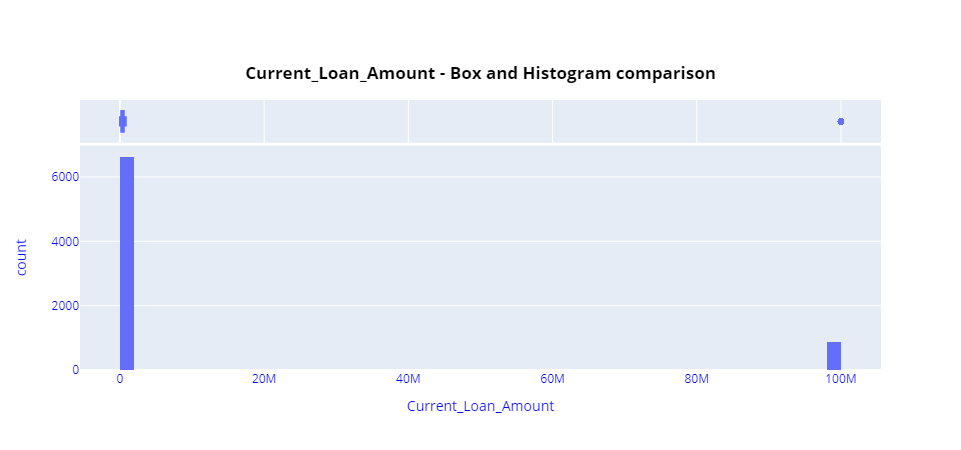

In [186]:
import plotly.express as px
# df = px.data.tips()
df = trainDf
x = 'Current_Loan_Amount'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

fig = px.histogram(df, x=x, nbins=50,
                   marginal="box", # or violin, rug
#                    hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )
fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()

 - As observed above, "Current_Loan_Amount" is having **870** samples, which are having the values near to 100 Million. We need to find a strategy to handle the outliers based on how much this feature is correlated to the target feature - 'Credit_Default'
 - We will handle the outliers for this feature - "Current_Loan_Amount" as we move forward with our EDA, as the outlier count is 870 samples.

### Univariate Analysis of feature - Maximum_Open_Credit

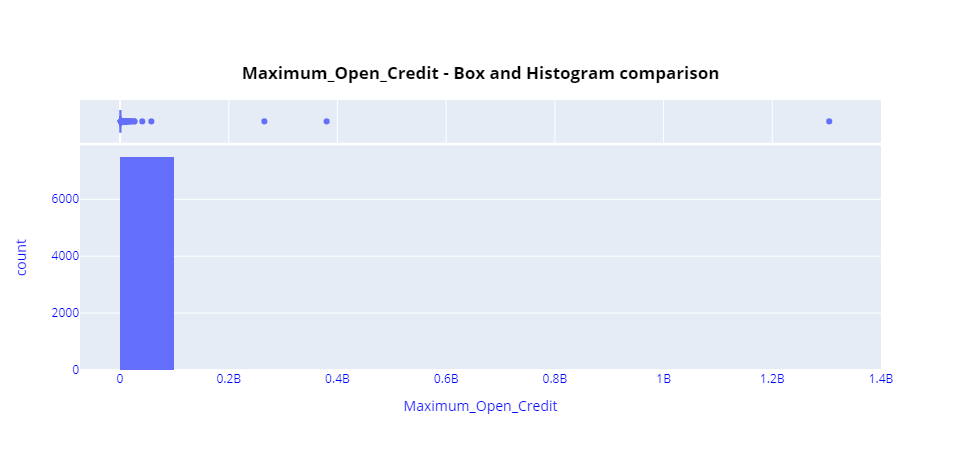

In [188]:
import plotly.express as px
# df = px.data.tips()
df = trainDf
x = 'Maximum_Open_Credit'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x, color=y, nbins=20,
#                    marginal="box", # or violin, rug
# #                    hover_data=df.columns,
#                    title=f'<b>{x} - Box and Histogram comparison',
#                    )

fig = px.histogram(df, x=x, nbins=20,
                   marginal="box", # or violin, rug
#                    hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )

fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()

 - From the above plot, we notice that feature - "Maximum_Open_Credit" is having 3 outlier observations which are above 250M Maximum_Open_Credit.
 - We shall gracefully delete those observations from the data set as below

In [189]:
outliers_Maximum_Open_Credit = trainDf.loc[(trainDf['Maximum_Open_Credit']>250.0*1000000)]
display(outliers_Maximum_Open_Credit)
trainDf = trainDf.drop(outliers_Maximum_Open_Credit.index).reset_index(drop=True)

Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
44      44  Have Mortgage    1334256.000            10+ years      0.000   
617    617  Home Mortgage            nan              3 years      0.000   
2617  2617  Home Mortgage    3217802.000            10+ years      0.000   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
44                     17.000                   15.400        380052288.000   
617                    13.000                   27.500       1304726170.000   
2617                   12.000                   35.500        265512874.000   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
44                        1.000                        35.000         0.000   
617                       0.000                           nan         0.000   
2617                      0.000                           nan         0.000   

                 Purpose        Term  Current_Loan_Amount  \
44           take a trip  Short Term            33110.000   
617   debt consolidation  Short Term           529892.000   
2617               other  Short Term            50116.000   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
44                656450.000     34357.000       729.000               0  
617              1126814.000      5492.000           nan               0  
2617             1834450.000     20272.000       750.000               0

### Univariate Analysis of feature - Current_Credit_Balance

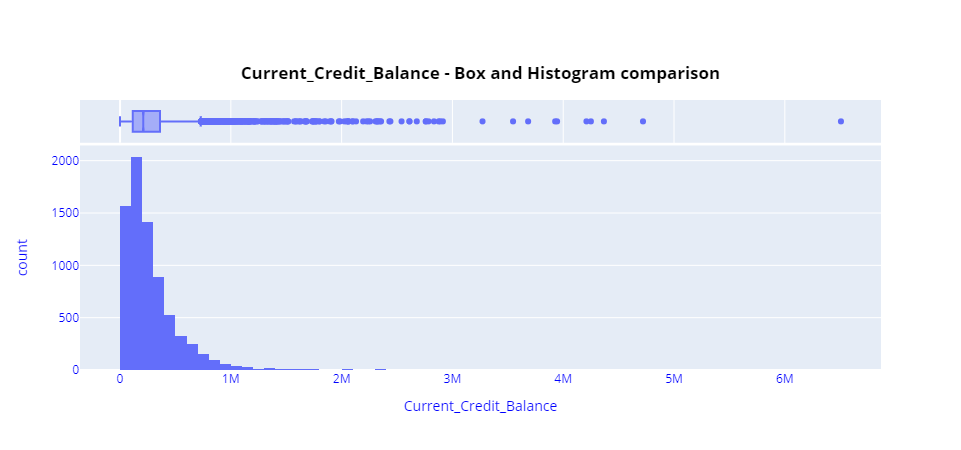

In [190]:
# df = px.data.tips()
df = trainDf
x = 'Current_Credit_Balance'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x, color=y, nbins=20,
#                    marginal="box", # or violin, rug
# #                    hover_data=df.columns,
#                    title=f'<b>{x} - Box and Histogram comparison',
#                    )

fig = px.histogram(df, x=x, nbins=100,
                   marginal="box", # or violin, rug
#                    hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )

fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()

In [192]:
# dropping the outliers which are above 2M
outliers_Current_Credit_Balance = trainDf.loc[(trainDf['Current_Credit_Balance']>5.0*1000000)]
display(outliers_Current_Credit_Balance)
display(outliers_Current_Credit_Balance.shape)
trainDf = trainDf.drop(outliers_Current_Credit_Balance.index).reset_index(drop=True)

Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
4766  4769  Home Mortgage    3739960.000              9 years      0.000   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
4766                    7.000                   22.800         26343328.000   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
4766                      0.000                           nan         0.000   

                Purpose        Term  Current_Loan_Amount  \
4766  home improvements  Short Term           757834.000   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
4766             6506797.000     38023.000       703.000               0

(1, 18)

### Univariate Analysis of feature - Credit_Score

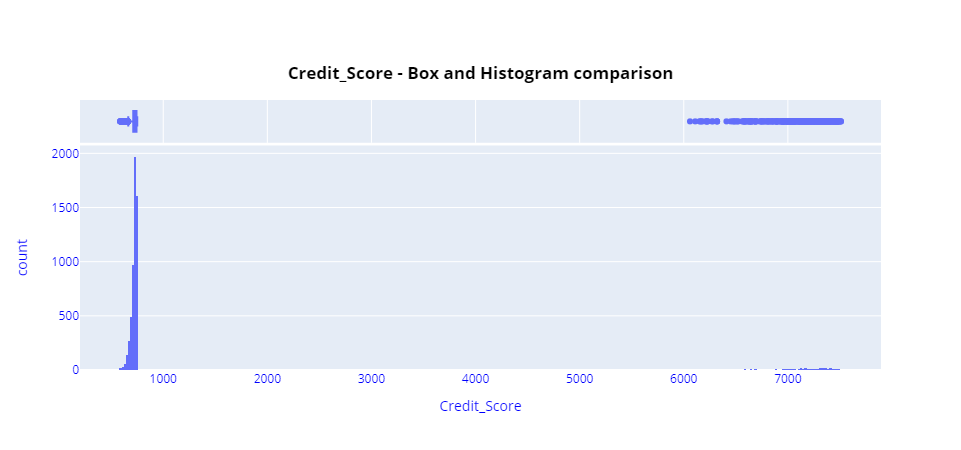

In [193]:
df = trainDf
x = 'Credit_Score'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x, color=y, nbins=20,
#                    marginal="box", # or violin, rug
# #                    hover_data=df.columns,
#                    title=f'<b>{x} - Box and Histogram comparison',
#                    )

fig = px.histogram(df, x=x, nbins=500,
                   marginal="box", # or violin, rug
#                    hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )

fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()

 - From the above graph, we notice that there are outliers in feature - "Credit_Score".
 - The usual Credit_Score values lie between 580 and 800, but the outlier values are in thousands. Looks like 10 has been multiplied by error while collecting the data.
 - Will handle the outliers by dividing the outlier values by 10 as below

In [194]:
trainDf['Credit_Score'] = [score/10 if score > 800 else score for score in trainDf['Credit_Score']]
trainDf

Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0        0       Own Home     482087.000                  NaN      0.000   
1        1       Own Home    1025487.000            10+ years      0.000   
2        2  Home Mortgage     751412.000              8 years      0.000   
3        3       Own Home     805068.000              6 years      0.000   
4        4           Rent     776264.000              8 years      0.000   
...    ...            ...            ...                  ...        ...   
7491  7495           Rent     402192.000             < 1 year      0.000   
7492  7496  Home Mortgage    1533984.000               1 year      0.000   
7493  7497           Rent    1878910.000              6 years      0.000   
7494  7498  Home Mortgage            nan                  NaN      0.000   
7495  7499           Rent            nan              4 years      0.000   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                      11.000                   26.300           685960.000   
1                      15.000                   15.300          1181730.000   
2                      11.000                   35.000          1182434.000   
3                       8.000                   22.500           147400.000   
4                      13.000                   13.600           385836.000   
...                       ...                      ...                  ...   
7491                    3.000                    8.500           107866.000   
7492                   10.000                   26.500           686312.000   
7493                   12.000                   32.100          1778920.000   
7494                   21.000                   26.500          1141250.000   
7495                    8.000                    9.400           480832.000   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                         1.000                           nan         1.000   
1                         0.000                           nan         0.000   
2                         0.000                           nan         0.000   
3                         1.000                           nan         1.000   
4                         1.000                           nan         0.000   
...                         ...                           ...           ...   
7491                      0.000                           nan         0.000   
7492                      0.000                        43.000         0.000   
7493                      0.000                           nan         0.000   
7494                      0.000                           nan         0.000   
7495                      0.000                           nan         0.000   

                 Purpose        Term  Current_Loan_Amount  \
0     debt consolidation  Short Term         99999999.000   
1     debt consolidation   Long Term           264968.000   
2     debt consolidation  Short Term         99999999.000   
3     debt consolidation  Short Term           121396.000   
4     debt consolidation  Short Term           125840.000   
...                  ...         ...                  ...   
7491               other  Short Term           129360.000   
7492  debt consolidation   Long Term           444048.000   
7493           buy a car  Short Term         99999999.000   
7494  debt consolidation  Short Term           615274.000   
7495  debt consolidation  Short Term            26928.000   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                  47386.000      7914.000       749.000               0  
1                 394972.000     18373.000       737.000               1  
2                 308389.000     13651.000       742.000               0  
3                  95855.000     11338.000       694.000               0  
4                  93309.000      7180.000       719.000               0  
...           

### Univariate Analysis of feature - Monthly_Debt 

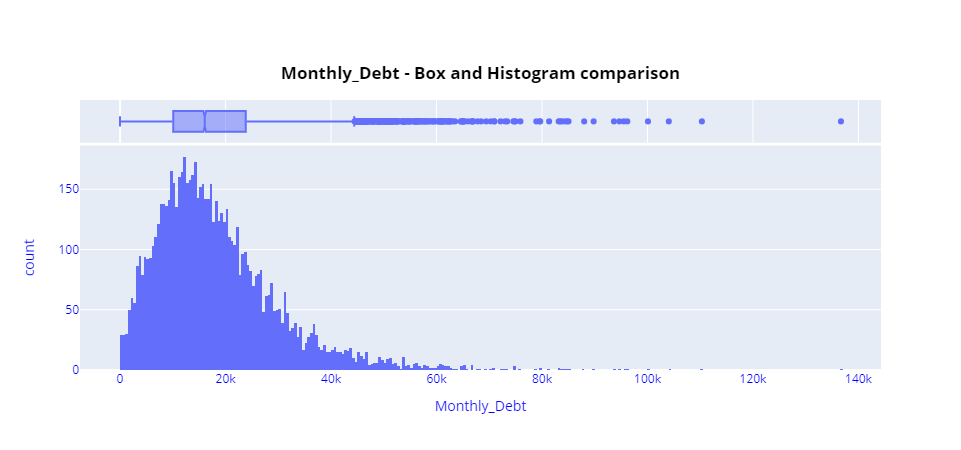

In [195]:
df = trainDf
x = 'Monthly_Debt'
y = 'Credit_Default'

# fig = px.histogram(df, x="total_bill", y="tip", color="sex",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x,
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)

# fig = px.histogram(df, x=x, color=y, nbins=20,
#                    marginal="box", # or violin, rug
# #                    hover_data=df.columns,
#                    title=f'<b>{x} - Box and Histogram comparison',
#                    )

fig = px.histogram(df, x=x, nbins=500,
                   marginal="box", # or violin, rug
#                    hover_data=df.columns,
                   title=f'<b>{x} - Box and Histogram comparison',
                   )

fig.update_layout(
#     font_family="Courier New",
    font_color="blue",
#     title_font_family="Times New Roman",
    title_font_color="black",
    legend_title_font_color="green",
    title_x=0.5,
    title_y=0.85,
    title_xanchor='center'
)
fig.show()

In [197]:
# dropping the outliers which are above 2M
outliers_Monthly_Debt = trainDf.loc[(trainDf['Monthly_Debt']>120.0*1000)]
display(outliers_Current_Credit_Balance)
display(outliers_Current_Credit_Balance.shape)
trainDf = trainDf.drop(outliers_Current_Credit_Balance.index).reset_index(drop=True)

Id Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
4766  4769  Home Mortgage    3739960.000              9 years      0.000   

      Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
4766                    7.000                   22.800         26343328.000   

      Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
4766                      0.000                           nan         0.000   

                Purpose        Term  Current_Loan_Amount  \
4766  home improvements  Short Term           757834.000   

      Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
4766             6506797.000     38023.000       703.000               0

(1, 18)

### Univariate Categorical feature analysis
 -  Below are the list of categorical features to be analyzed  
 ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

### Univariate Analysis of categorical feature - "Home_Ownership"

<AxesSubplot:xlabel='Home_Ownership', ylabel='Id'>

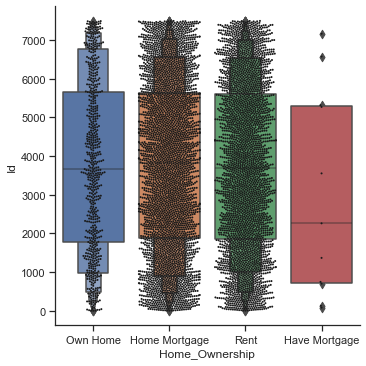

In [212]:
g = sns.catplot(x="Home_Ownership", y="Id", kind="boxen", data=trainDf)
sns.swarmplot(x="Home_Ownership", y="Id", color="k", size=2, data=trainDf, ax=g.ax)

In [209]:
trainDf['Home_Ownership'].value_counts()

Home Mortgage    3633
Rent             3204
Own Home          647
Have Mortgage      11
Name: Home_Ownership, dtype: int64

 - Looks like Home_Ownership is having the mis-spelled word - 'Have Mortgage' instead of 'Home Mortgage'
 - We will replace the 'Have Mortgage' 11 samples with 'Home Mortgage'

In [214]:
trainDf['Home_Ownership'] = trainDf['Home_Ownership'].replace({'Have Mortgage': 'Home Mortgage'})
trainDf['Home_Ownership'].value_counts()

Home Mortgage    3644
Rent             3204
Own Home          647
Name: Home_Ownership, dtype: int64

### Univariate Analysis of categorical feature - "Years_in_current_job"

<AxesSubplot:xlabel='Years_in_current_job', ylabel='Id'>

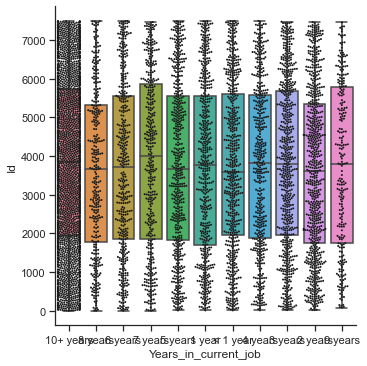

In [219]:
g = sns.catplot(x="Years_in_current_job", y="Id", kind="box", data=trainDf)
sns.swarmplot(x="Years_in_current_job", y="Id", color="k", size=2, data=trainDf, ax=g.ax)

In [218]:
trainDf['Years_in_current_job'].value_counts()

10+ years    2330
2 years       705
3 years       619
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       425
7 years       396
8 years       339
9 years       258
Name: Years_in_current_job, dtype: int64

 - Looks like Years_in_current_job is looking good. No changes required

### Univariate Analysis of categorical feature - "Purpose"

<AxesSubplot:xlabel='Purpose', ylabel='Id'>

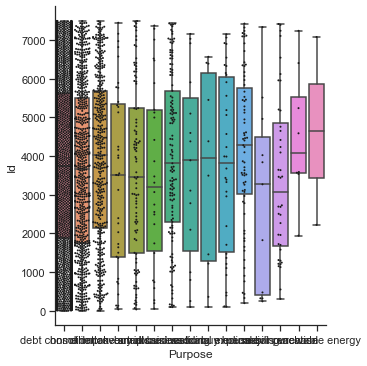

In [220]:
g = sns.catplot(x="Purpose", y="Id", kind="box", data=trainDf)
sns.swarmplot(x="Purpose", y="Id", color="k", size=2, data=trainDf, ax=g.ax)

In [221]:
trainDf['Purpose'].value_counts()

debt consolidation      5943
other                    663
home improvements        411
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               36
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64